In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from qutip import *
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import simpson
plt.rcParams.update({'font.size': 14})

In [2]:
def coper(N,q0,myu):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    const1=myu*(q0**2-1)
    const2=3*myu/4
    c1=sqrt(const1)*adag
    c2=sqrt(const2)*a**2
    c3=sqrt(myu)*(adag*a-0.5*adag**2)
    cops.append(c1)
    cops.append(c2)
    cops.append(c3)
    return cops
def hamil(N,omega,q0,myu):
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    H=omega*adag*a+(1j*zeta*(adag*a**3-(adag**3)*a))+(1j*beta*(a**4-adag**4))-(1j*eta*(a**2-adag**2))
    return H
def retdiag(rho,N):
    rhoii=[]
    n=[]
    for i in range(N):
        rhoii.append(rho.diag())
        n.append(i+1)
    return n,rhoii
def retdens(H,cops,N):
    expop=rand_dm(N)
    times = np.linspace(0.0, 100.0, 1000)
    result_dm = mesolve(H, expop, times, cops)
    return result_dm.states    
def hamildriven(N,omega,q0,myu,n,omega1,epsilon,phi):
    T=2*np.pi/omega1
    t=np.linspace(0,1000,1000)
    t=t*T
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    H=[]
    for i in range (len(t)):
        H.append(omega*adag*a+(1j*zeta*(adag*a**3-(adag**3)*a))+(1j*beta*(a**4-adag**4))-(1j*eta*(a**2-adag**2))-(1j*epsilon*t[i]*(a+adag)))
    return H    
    #H=omega*adag*a+(1j*zeta*(adag*a**3-(adag**3)*a))+(1j*beta*(a**4-adag**4))-(1j*eta*(a**2-adag**2))-(cosine)
    
    return H
def Gauss(x, A, B, C):
    y = A*np.exp(-((x-B)/C)**2)
    return y
def twovdpcoper1(N,q0,myu):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    I=qeye(N)
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    const1=myu*(q0**2-1)
    const2=3*myu/4
    c1=sqrt(const1)*tensor(adag,I)
    c2=sqrt(const2)*(tensor(a**2,I))
    c3=sqrt(myu)*(tensor(adag*a,I)-0.5*tensor(adag**2,I))
    cops.append(c1)
    cops.append(c2)
    cops.append(c3)
    return cops
def twovdpcoper2(N,q0,myu):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    I=qeye(N)
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    const1=myu*(q0**2-1)
    const2=3*myu/4
    c1=sqrt(const1)*tensor(I,adag)
    c2=sqrt(const2)*(tensor(I,a**2))
    c3=sqrt(myu)*(tensor(I,adag*a)-0.5*tensor(I,adag**2))
    cops.append(c1)
    cops.append(c2)
    cops.append(c3)
    return cops
    
def twovdpcouplingcoper(cops1,cops2,N,D):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    I=qeye(N)
    for i in range(len(cops1)):
        cops.append(cpos1[i])
    for i in range(len(cops2)):
        cops.append(cpos2[i])
    c3=sqrt(D)*(tensor(a,I)-tensor(I,a))
    cops.append(c3)
    return cops
def linexp(x,A,alpha,mean):
    y=A*(x**2)*np.exp(-(alpha)*(x-mean)**2)
    #y=A*x
    return y
def probrec(myu,q0,diag):
    N=3000
    p=np.zeros(N)
    #p[0]=np.random.uniform(0,1)
    #p[1]=np.random.uniform(0,1)
    #p[2]=np.random.uniform(0,1)
    p[0]=0
    p[1]=diag[0]
    p[2]=diag[1]
    #p[2]=np.random.uniform(0,1)
    n=0
    for i in range(N-3):
        if n!=-2:
            
            p[i+3]=-(4/(3*myu*(n+2)))*(((-myu*(q0**2-1))*p[i+1])+((3*myu/4)*(n*p[i+2]))-((myu/4)*(n*p[i]+(n+2)*p[i+1])))
        n+=1
    probshift=np.zeros(len(p))
    probshift[0]=p[1]
    for i in range(len(p)-1):
        probshift[i]=p[i+1]
    return probshift
def backrec(myu,q0):
    N=1000
    p=np.zeros(N)
    p[0]=np.random.uniform(0,1)
    p[1]=np.random.uniform(0,1)
    p[2]=np.random.uniform(0,1)
    n=999
    for i in range(N-3):
        p[i+3]=(1/n)*(((-4*(q0**2-1))*p[i+2])+(3*(n*p[i+1]+(n+2)*p[i])-((n+2)*p[i+2])))
        n-=1
    return p
def propagator_m(H, tlist):
    if not(H.isoper):
        raise Exception('H should be an Hermitian operator.')
    N = H.shape[0]
    dims = H.dims
    if isinstance(tlist, (int, float, np.integer, np.floating)):
        return (-1j * H * tlist).expm()
    elif isinstance(tlist, (np.ndarray, list)):
        step = len(tlist)
        evals, evecs = la.eigh(H.full())
        u = np.zeros([N, N, step], dtype=complex)
        for i in range(step):
            u[:, :, i] = (evecs @ np.diag(np.exp(evals * (-1j) * tlist[i]))) @ evecs.T.conj()
        return np.array([
            Qobj(u[:, :, k], dims=dims)
            for k in range(step)
        ], dtype=object)
    else:
        raise TypeError('Incorrect type of tlist: tlist should be a\
         list or np.ndarray.')



In [4]:
q0=3
omega=1
N=30

In [17]:
myu=0.0001
H1=hamil(N,omega,q0,myu)
cops1=coper(N,q0,myu)
n=np.linspace(0,29,30)

In [18]:
ss1=steadystate(H1,cops1)

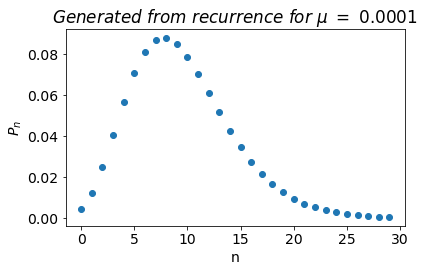

In [19]:
prob=probrec(myu,q0,ss1.diag())
prob
plt.scatter(n,(prob[0:30]))
plt.ylabel(r'$P_n$')
plt.xlabel('n')
plt.title(r'$Generated$ $from$ $recurrence$ $for$ $\mu$ $=$ $0.0001$')
plt.tight_layout()
plt.savefig('rec0.0001.png')

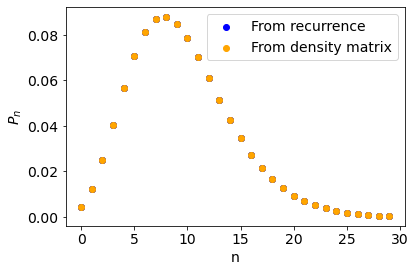

In [20]:
plt.scatter(n,ss1.diag())
plt.scatter(n,(prob[0:30]))
plt.scatter(n,prob[0:30],label='From recurrence',c='b')
plt.scatter(n,ss1.diag(),label='From density matrix',c='orange')
plt.ylabel(r'$P_n$')
plt.xlabel('n')
plt.legend()
plt.tight_layout()
plt.savefig('recsuper0.0001.png')

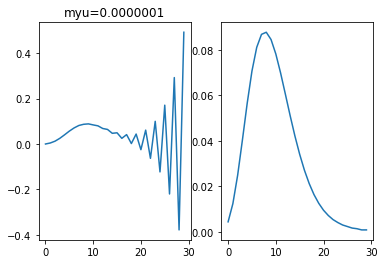

In [42]:
myu=0.01
H=hamil(N,omega,q0,myu)
cops=coper(N,q0,myu)

ss=steadystate(H,cops)

prob=probrec(myu,q0,ss.diag())
prob
plt.subplot(1, 2, 1)
plt.plot((prob[0:30]))
plt.title('myu=0.0000001')

plt.subplot(1, 2, 2)
plt.plot(ss.diag())

In [43]:
ss

Quantum object: dims = [[30], [30]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[ 4.40869137e-03+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.84225086e-05-1.86071767e-04j  0.00000000e+00+0.00000000e+00j
   5.59687383e-06+2.62422241e-05j  0.00000000e+00+0.00000000e+00j
  -1.13012152e-06+1.54921375e-07j  0.00000000e+00+0.00000000e+00j
   2.21270995e-08-3.41247404e-08j  0.00000000e+00+0.00000000e+00j
   2.06391320e-10+2.40836547e-09j  0.00000000e+00+0.00000000e+00j
  -8.59285197e-11+4.90297208e-11j  0.00000000e+00+0.00000000e+00j
  -6.13813373e-12+1.21489257e-11j  0.00000000e+00+0.00000000e+00j
  -9.23499918e-13-8.95215509e-13j  0.00000000e+00+0.00000000e+00j
   2.52026742e-13+2.69513544e-14j  0.00000000e+00+0.00000000e+00j
  -1.23259508e-14+3.55744865e-14j  0.00000000e+00+0.00000000e+00j
  -2.95627662e-15-2.90521456e-15j  0.00000000e+00+0.00000000e+00j
   5.99120404e-16-1.12348973e-16j  0.00000000e+00+0.00000000e+00j
  -3.24178582e-18+8.57494746e-17j  0.00000000e+0

Text(0.5, 1.0, 'myu=0.000001')

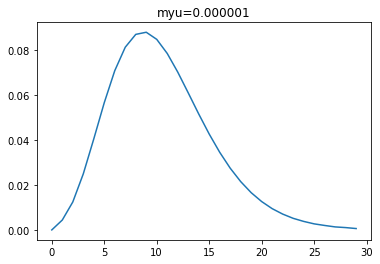

In [44]:
myu=0.000001
H=hamil(N,omega,q0,myu)
cops=coper(N,q0,myu)

ss=steadystate(H,cops)

prob=probrec(myu,q0,ss.diag())
prob
plt.plot((prob[0:30]))
plt.title('myu=0.000001')

Text(0.5, 1.0, 'myu=0.000001')

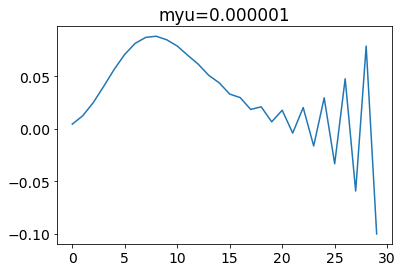

In [69]:
myu=0.004
H=hamil(N,omega,q0,myu)
cops=coper(N,q0,myu)

ss=steadystate(H,cops)

prob=probrec(myu,q0,ss.diag())
prob
plt.plot((prob[0:30]))
plt.title('myu=0.000001')

Text(0.5, 1.0, 'myu=0.0001')

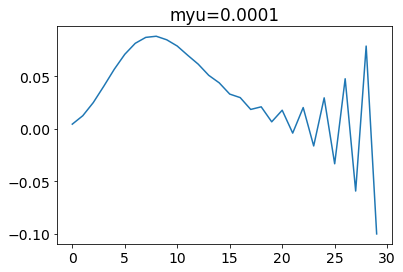

In [49]:
myu=0.004
H=hamil(N,omega,q0,myu)
cops=coper(N,q0,myu)

ss=steadystate(H,cops)

prob=probrec(myu,q0,ss.diag())
prob
plt.plot((prob[0:30]))
plt.title('myu=0.0001')

In [47]:
ss

Quantum object: dims = [[30], [30]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[ 4.39525707e-03+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.82859116e-07-1.86465451e-05j  0.00000000e+00+0.00000000e+00j
   5.51978485e-08+2.66200267e-06j  0.00000000e+00+0.00000000e+00j
  -1.11082686e-08+1.42779258e-10j  0.00000000e+00+0.00000000e+00j
   2.27464246e-10-3.05145620e-11j  0.00000000e+00+0.00000000e+00j
  -2.27973856e-14+1.73483856e-12j  0.00000000e+00+0.00000000e+00j
   2.32030323e-15+1.52521354e-13j  0.00000000e+00+0.00000000e+00j
  -2.48395833e-15+2.59678856e-16j  0.00000000e+00+0.00000000e+00j
   1.95256939e-16-3.70275851e-17j  0.00000000e+00+0.00000000e+00j
   6.49635916e-19+4.74337492e-18j  0.00000000e+00+0.00000000e+00j
  -7.89766464e-20-1.78425220e-19j  0.00000000e+00+0.00000000e+00j
   6.39937160e-21-1.34466630e-21j  0.00000000e+00+0.00000000e+00j
  -1.46801742e-22+1.36500514e-22j  0.00000000e+00+0.00000000e+00j
  -2.61939968e-24-7.91313570e-24j  0.00000000e+0

In [48]:
a=destroy(N)
adag=a.dag()
taulist=np.linspace(0,100,1000)
init=rand_dm(N)

In [15]:
corr=correlation_2op_1t(H, init, taulist, cops, a, adag, solver='me', reverse=False)

In [16]:
corr

array([ 1.49597711e+01+0.00000000e+00j,  1.48508394e+01-1.49178568e+00j,
        1.45942993e+01-2.96215109e+00j,  1.41933549e+01-4.39669021e+00j,
        1.36526123e+01-5.78139523e+00j,  1.29780278e+01-7.10278857e+00j,
        1.21768415e+01-8.34805195e+00j,  1.12575000e+01-9.50515122e+00j,
        1.02295670e+01-1.05629553e+01j,  9.10362604e+00-1.15113465e+01j,
        7.89117511e+00-1.23413206e+01j,  6.60451419e+00-1.30450744e+01j,
        5.25662689e+00-1.36160787e+01j,  3.86105623e+00-1.40491379e+01j,
        2.43177504e+00-1.43404348e+01j,  9.83051669e-01-1.44875611e+01j,
       -4.70688149e-01-1.44895353e+01j, -1.91500226e+00-1.43468071e+01j,
       -3.33557434e+00-1.40612500e+01j, -4.71835592e+00-1.36361400e+01j,
       -6.04970644e+00-1.30761225e+01j, -7.31652966e+00-1.23871654e+01j,
       -8.50640453e+00-1.15764992e+01j, -9.60770887e+00-1.06525441e+01j,
       -1.06097343e+01-9.62482413e+00j, -1.15027909e+01-8.50387017e+00j,
       -1.22783009e+01-7.30111164e+00j, -1.29288799

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


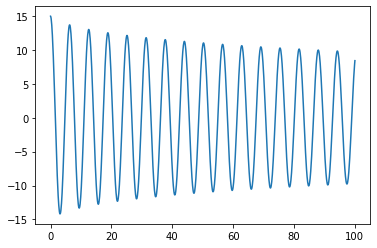

In [17]:
plt.plot(taulist,corr)

In [18]:
atau=[]
h=H.full()
for i in range(len(taulist)):
    U=exp(-1j*h*i)
    U=np.matrix(U)
    Udag=U.getH()
    atau.append(Udag*a*U)


In [19]:
atau[0]

matrix([[106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j],
        [106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561964+0.j,
         106.60561964+0.j, 106.60561964+0.j, 106.60561

In [20]:
atauq=Qobj(atau[0])
atauq

Quantum object: dims = [[30], [30]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964]
 [106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.60561964 106.60561964 106.60561964]
 [106.60561964 106.60561964 106.60561964 106.60561964 106.60561964
  106.60561964 106.60561964 106.6

In [21]:
dm=mesolve(H, init, taulist, cops).states

In [22]:
ex=[]
for i in range(len(taulist)):
    at=Qobj(atau[i])  
    ex.append(expect(at*a,dm[i]))

In [23]:
ex

[(523.911195143974-78.27968706484836j),
 (330.62700068540124+31.543170752393568j),
 (529.6053869694224+27.041645060538723j),
 (385.664670046462-45.53620205356004j),
 (299.07025132083913+29.850046693057845j),
 (381.103308646468+6.223026802087706j),
 (344.8359482821468-17.363379838701604j),
 (309.7035565758765-16.561151207209573j),
 (263.08573461136126-10.659353475551171j),
 (275.37872071260466+6.383984016560463j),
 (302.82037055473927-2.806796755595194j),
 (361.79960933447137+12.754927027553125j),
 (377.68113043514876-8.020819501450877j),
 (338.1745168964271-6.9546611180118605j),
 (330.0074979250458+1.5820977284341415j),
 (304.3557755472174+6.765456043609206j),
 (326.5635289493661+13.834823238725374j),
 (326.0241331545714-10.738770036125482j),
 (276.97433857804447-9.032855238581686j),
 (276.7807212028313+7.847582474276027j),
 (300.0513102203379-0.0031725588526553272j),
 (275.37221946633974-3.8790994111573367j),
 (268.80850844652167-0.21436513139019284j),
 (286.172034841484+3.18789782137

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


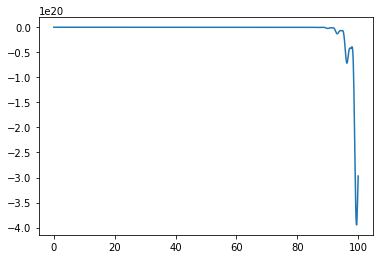

In [24]:
plt.plot(taulist,ex)

In [25]:
N=adag*a
ntau=[]
h=H.full()
for i in range(len(taulist)):
    U=exp(-1j*h*i)
    U=np.matrix(U)
    Udag=U.getH()
    ntau.append(Udag*N*U)


In [26]:
nex=[]
for i in range(len(taulist)):
    nt=Qobj(ntau[i])  
    nex.append(expect(commutator(nt,N)**2,dm[i]))

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


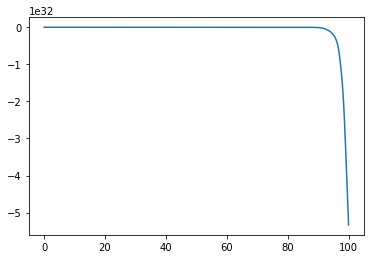

In [27]:
plt.plot(taulist,nex)

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


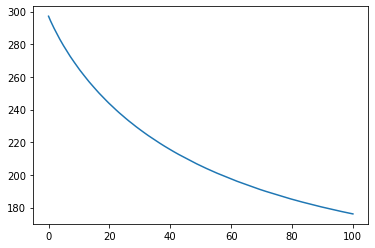

In [28]:
corr=correlation_2op_1t(H, init, taulist, cops, N, N, solver='me', reverse=False)
plt.plot(taulist,corr)

In [29]:
ntau=mesolve(H, N, taulist, cops).states

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


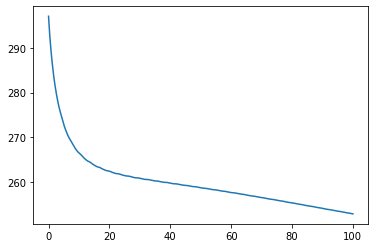

In [30]:
nn=[]
for i in range(len(taulist)):
    nt=Qobj(ntau[i])  
    nn.append(expect(nt*N,dm[i]))
plt.plot(taulist,nn)

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


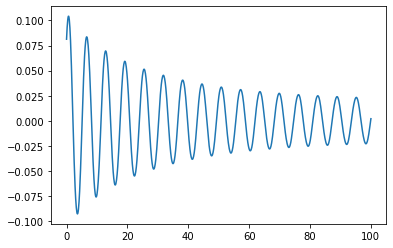

In [31]:
corr=correlation_2op_1t(H, init, taulist, cops, a, a, solver='me', reverse=False)
plt.plot(taulist,corr)

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


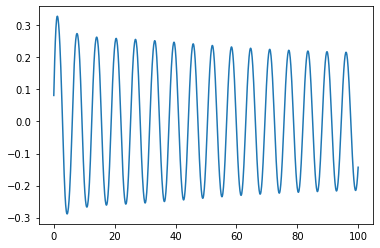

In [32]:
atau=mesolve(H, a, taulist, cops).states
aa=[]
for i in range(len(taulist)):
    at=Qobj(atau[i])  
    aa.append(expect(at*a,dm[i]))
plt.plot(taulist,aa)

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


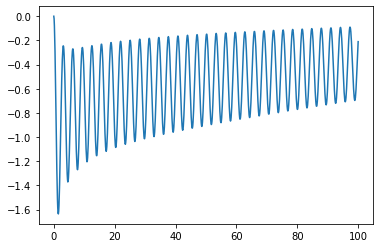

In [33]:
n2=[]
for i in range(len(taulist)):
    nt=Qobj(ntau[i])
    e=expect(nt*N*nt*N,dm[i])+expect(N*nt*N*nt,dm[i])-expect(nt*N*N*nt,dm[i])-expect(N*nt*nt*N,dm[i])
    n2.append(e)
plt.plot(taulist,n2)

C:\Users\tamoj\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


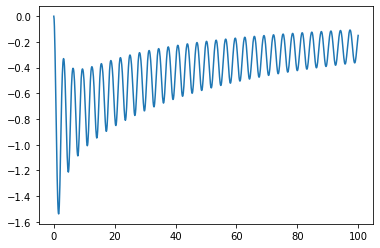

In [34]:
n2=[]
for i in range(len(taulist)):
    nt=Qobj(ntau[i])
    e=expect(nt*N*nt*N,init)+expect(N*nt*N*nt,init)-expect(nt*N*N*nt,init)-expect(N*nt*nt*N,init)
    n2.append(e)
plt.plot(taulist,n2)